In [1]:
# %load ../../utility/initialization.py
'''
How to Train Your Dragon: V1
Sequentially initialize FT reactive distillation model automatically
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

# sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify, \
                                    beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_violate_constraint
from utility.data_utility import cal_cnumber

'''
Constructing the model and logfile
'''

model = pe.ConcreteModel(name='reactive_distillation')
logname = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')
log_text_dir = './log/text/'+logname+'.dat'
log_figure_dir = './log/figure/'+logname+'.pdf'

with PdfPages(log_figure_dir,keep_empty=False) as pdf:

    '''
    model input
    '''
    tray_number = 10
    non_reactive_flag = [1,2,3,5,10]
    # non_reactive_flag = []
    side_draw_flag = {4:0.2,7:0.7}
    # default temperature is
    temperature_flag = {6:240,7:240,8:245,9:250}
    rr_ratio = 0.05

    '''
    construct the reactive stages
    '''
    model.TRAY = pe.RangeSet(1,tray_number)
    model.TRAY_nonreactive = pe.Set(initialize=non_reactive_flag)
    model.TRAY_reactive = model.TRAY - model.TRAY_nonreactive

    with HiddenPrints():
        model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)
        add_dual(pe,model)

    '''
    setting stream variables
    '''
    # in/out variable
    for j in model.reactive:
        model.reactive[j].x_.fix(0)
        model.reactive[j].y_.fix(0)
        model.reactive[j].L['in'].fix(0)
        model.reactive[j].V['in'].fix(0)
        model.reactive[j].H_L_.fix(0)
        model.reactive[j].H_V_.fix(0)

    # operating parameters
    for j in model.reactive:
        model.reactive[j].cat.fix(3000)
        model.reactive[j].P.fix(20)
        model.reactive[j].VLE_block.n_ave.fix(20)

        model.reactive[j].F.fix(1)
        model.reactive[j].T_F.fix(200+273.15)
        model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
        model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
        model.reactive[j].z['C30H62'].fix(0)

        model.reactive[j].PR_L.fix(1)
        model.reactive[j].PR_V.fix(1)

        # model.reactive[j].Q_main.fix(0)
        model.reactive[j].T.setub(220+273.15)
        model.reactive[j].T.setlb(200+273.15)

    model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf \
                                        for j in model.reactive),sense=pe.maximize)

    '''
    solver options
    '''
    opt = pe.SolverFactory('ipopt')

    opt.options['print_user_options'] = 'yes'
    opt.options['linear_solver'] = 'ma86'

    opt.options['linear_system_scaling '] = 'mc19'
    opt.options['linear_scaling_on_demand '] = 'no'

    opt.options['max_iter'] = 7000

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    with HiddenLogs(log_text_dir,'w'):
        print('\nFirst Solve, disconnected reactive stages')
        print('-'*108)
        beautify_reactive(pe,model)
    
    '''
    connect reactive stages
    '''

    def V_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
    model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

    def Vy_between_rule(model,j,i):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
    model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

    def Vh_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
    model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

    def L_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
    model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

    def Lx_between_rule(model,j,i):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
    model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

    def Lh_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
    model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

    for j in model.reactive:
        if j != model.TRAY.first():
            model.reactive[j].x_.unfix()
            model.reactive[j].H_L_.unfix()
            model.reactive[j].L['in'].unfix()
        if j != model.TRAY.last():
            model.reactive[j].y_.unfix()
            model.reactive[j].V['in'].unfix()
            model.reactive[j].H_V_.unfix()

    '''
    warm start options
    '''        

    opt.options['warm_start_init_point'] = 'yes'
    opt.options['warm_start_bound_push'] = 1e-20
    opt.options['warm_start_mult_bound_push'] = 1e-20
    opt.options['mu_init'] = 1e-6

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    '''
    The model above has liquid and vapor leave stage as products
    Now we will let liquid and vapor flow through up/down stages
    '''

    PR_range = np.linspace(1,0,11)
    with HiddenLogs(log_text_dir):
        print('\nConnect stages and introduce inter-stage flow')
    for r in PR_range:
        for j in model.reactive:
            model.reactive[j].PR_L.fix(r)
            model.reactive[j].PR_V.fix(r)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        with HiddenLogs(log_text_dir):
            print('\n>','Working on PR ratio = {:.2f}'.format(r))
            print('-'*108)
            beautify_reactive(pe,model)
    
    '''
    Following design specification, remove non-reactive stages' catalyst and feed
    ''' 

    for j in model.TRAY_nonreactive:

        model.reactive[j].T.unfix()
        model.reactive[j].Q_main.fix(0)
        model.reactive[j].cat.fix(0)
        model.reactive[j].F.fix(0)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        with HiddenLogs(log_text_dir):
            print('\n>','Working to remove catalyst and feed from stage {}, unfixing temperature, changing to adiabatic:'.format(j))
            print('-'*108)
            beautify_reactive(pe,model)
    
    '''
    Deactivate reactive part of the model to initialize condenser and reboiler
    '''    

    for i in model.block_data_objects():
        if i.name != 'reactive_distillation':
            i.deactivate()
    for i in model.component_objects(pe.Constraint, active=True):
        i.deactivate()

    with HiddenPrints():
        model.condenser = pe.Block(rule=condenser_stage_rule)
        delete_dual(pe,model)
        add_dual(pe,model)
        
    '''
    setting condenser stream variables to match reactive stages vapor output
    '''

    # in/out variables
    model.condenser.x_.fix(0)
    for i in m.COMP_TOTAL:
        model.condenser.y_['in',i].fix(model.reactive[model.TRAY.first()].y[i].value)
    model.condenser.V['in'].fix(model.reactive[model.TRAY.first()].V['out'].value)
    model.condenser.L['in'].fix(0)
    model.condenser.V['P'].fix(0)
    model.condenser.H_L_.fix(0)
    model.condenser.H_V_.fix(model.reactive[model.TRAY.first()].H_V.value)

    # operating parameters
    model.condenser.P.fix(19)
    model.condenser.T_F.fix(200+273.15)
    model.condenser.F.fix(0)
    model.condenser.z.fix(0)
    model.condenser.VLE_block.n_ave.fix(4)
    model.condenser.PR_L.fix(1)

    model.condenser.T.setub(30+273.15)

    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.condenser.T, sense = pe.maximize)

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    model.condenser.deactivate()
    check_DOF(pe,model)

    with HiddenPrints():
        model.reboiler = pe.Block(rule=reboiler_stage_rule)
        delete_dual(pe,model)
        add_dual(pe,model)

    '''
    setting reboiler stream variables to match reactive stages vapor output
    '''

    # in/out variables
    model.reboiler.y_.fix(0)
    for i in m.COMP_TOTAL:
        model.reboiler.x_['in',i].fix(model.reactive[model.TRAY.last()].x[i].value)
    model.reboiler.L['in'].fix(model.reactive[model.TRAY.last()].L['out'].value)
    model.reboiler.V['in'].fix(0)
    model.reboiler.L['P'].fix(0)
    model.reboiler.V['P'].fix(0)
    model.reboiler.H_L_.fix(model.reactive[model.TRAY.last()].H_L.value)
    model.reboiler.H_V_.fix(0)

    # operating parameters
    model.reboiler.P.fix(20)
    model.reboiler.T_F.fix(200+273.15)
    model.reboiler.F.fix(0)
    model.reboiler.z.fix(0)
    model.reboiler.VLE_block.n_ave.fix(20)

    model.reboiler.T.setub(model.reactive[model.TRAY.last()].T.value)

    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.reboiler.T - model.reboiler.MPCC.pf, sense = pe.maximize)

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    '''
    Now all the variables are initialized, reactivate everything, time to connect condenser and reboiler
    '''

    for i in model.block_data_objects():
        if i.name != 'reactive_distillation':
            i.activate()
    for i in model.component_objects(pe.Constraint):
        i.activate()

    def V_condenser_rule(model):
        return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
    model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

    def Vy_condenser_rule(model,i):
        return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
    model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

    def Vh_condenser_rule(model):
        return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
    model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

    def L_condenser_rule(model):
        return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
    model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

    def Lx_condenser_rule(model,i):
        return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
    model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

    def Lh_condenser_rule(model):
        return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
    model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

    def V_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].V['in'] == model.reboiler.V['out']
    model.V_reboiler_con = pe.Constraint(rule=V_reboiler_rule)

    def Vy_reboiler_rule(model,i):
        return model.reactive[model.TRAY.last()].y_['in',i] == model.reboiler.y[i]
    model.Vy_reboiler_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_reboiler_rule)

    def Vh_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].H_V_['in'] == model.reboiler.H_V
    model.Vh_reboiler_con = pe.Constraint(rule=Vh_reboiler_rule)

    def L_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].L['out'] + 1e-6 == model.reboiler.L['in']
    model.L_reboiler_con = pe.Constraint(rule=L_reboiler_rule)

    def Lx_reboiler_rule(model,i):
        return model.reactive[model.TRAY.last()].x[i] == model.reboiler.x_['in',i]
    model.Lx_reboiler_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_reboiler_rule)

    def Lh_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].H_L == model.reboiler.H_L_['in']
    model.Lh_reboiler_con = pe.Constraint(rule=Lh_reboiler_rule)

    model.del_component(model.obj)
    model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY_reactive)\
                            + sum( - model.reactive[j].MPCC.pf for j in model.TRAY_nonreactive) - model.reboiler.MPCC.pf ,sense=pe.maximize)

    with HiddenPrints():
        delete_dual(pe,model)
        add_dual(pe,model)

    '''
    Make sure all stream variables are set correctly
    '''

    # in/out variables
    model.condenser.x_.fix(0)
    for i in m.COMP_TOTAL:
        model.condenser.y_['in',i].unfix()
    model.condenser.V['in'].unfix()
    model.condenser.L['in'].fix(0)
    model.condenser.V['P'].fix(0)
    model.condenser.H_L_.fix(0)
    model.condenser.H_V_.unfix()

    # operating parameters
    model.condenser.P.fix(19)
    model.condenser.T_F.fix(200+273.15)
    model.condenser.F.fix(0)
    model.condenser.z.fix(0)
    model.condenser.VLE_block.n_ave.fix(4)
    model.condenser.PR_L.fix(1)

    model.condenser.T.fix(30+273.15)

    # in/out variables
    model.reboiler.y_.fix(0)
    for i in m.COMP_TOTAL:
        model.reboiler.x_['in',i].unfix()
    model.reboiler.L['in'].unfix()
    model.reboiler.V['in'].fix(0)
    model.reboiler.L['P'].fix(0)
    model.reboiler.V['P'].fix(0)
    model.reboiler.H_L_.unfix()
    model.reboiler.H_V_.fix(0)

    # operating parameters
    model.reboiler.P.fix(20)
    model.reboiler.T_F.fix(200+273.15)
    model.reboiler.F.fix(0)
    model.reboiler.z.fix(0)
    model.reboiler.VLE_block.n_ave.fix(20)

    model.reboiler.T.fix(model.reactive[model.TRAY.last()].T.value)

    # unlock reflux and reboiler vapor
    for j in model.reactive:
        model.reactive[j].x_.unfix()
        model.reactive[j].H_L_.unfix()
        model.reactive[j].L['in'].unfix()
        model.reactive[j].y_.unfix()
        model.reactive[j].V['in'].unfix()
        model.reactive[j].H_V_.unfix()

    for j in model.reactive:
        if j in model.TRAY_reactive:
            model.reactive[j].cat.fix(3000)
            model.reactive[j].P.fix(20)
            model.reactive[j].VLE_block.n_ave.fix(20)

            model.reactive[j].F.fix(1)
            model.reactive[j].T_F.fix(200+273.15)
            model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
            model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
            model.reactive[j].z['C30H62'].fix(0)

            model.reactive[j].PR_L.fix(0)
            model.reactive[j].PR_V.fix(0)

            # model.reactive[j].Q_main.fix(0)
            model.reactive[j].T.setub(220+273.15)
            model.reactive[j].T.setlb(200+273.15)

        elif j in model.TRAY_nonreactive:
            model.reactive[j].cat.fix(0)
            model.reactive[j].P.fix(20)
            model.reactive[j].VLE_block.n_ave.fix(20)

            model.reactive[j].F.fix(0)
            model.reactive[j].T_F.fix(200+273.15)
            model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
            model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
            model.reactive[j].z['C30H62'].fix(0)

            model.reactive[j].PR_L.fix(0)
            model.reactive[j].PR_V.fix(0)

            model.reactive[j].Q_main.fix(0)
            model.reactive[j].T.setub(350+273.15)
            model.reactive[j].T.setlb(100+273.15)

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    with HiddenLogs(log_text_dir):
        print('\nInitialized with no reflux and reboil complete')
        beautify(pe,model)

    '''
    Introduce reflux, in a gentle way.
    linspace for rr_ratio is not linear in terms of reflux flow, has to be modified
    '''
    R_range = np.linspace(0,1/rr_ratio-1,10)

    PR_range = 1/(1+R_range)

    for r in PR_range:
        model.condenser.PR_L.fix(r)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on Reflux, PR ratio = {:.2f}'.format(r))
            print('-'*108)
            beautify(pe,model)
        
        plot_distribution(model,pdf,'Refulx PR ratio = {:.2f}'.format(r))
            
            
    '''
    Start the reboiler
    '''    

    T_range = np.linspace(model.reboiler.T.value,350+273.15,2)
    for t in T_range:
        model.reboiler.T.fix(t)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on reboiler temperature = {:.2f}'.format(t))
            print('-'*108)
            beautify(pe,model)

    plot_distribution(model,pdf,'Reboiler')
    
    
    '''
    Extract side-draws
    '''    

    for j in side_draw_flag.keys():

        r = side_draw_flag[j]
        model.reactive[j].PR_L.fix(r)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on side draw of {:.1%} on stage {}'.format(r,j))
            print('-'*108)
            beautify(pe,model)
        plot_distribution(model,pdf,'Side draw of {:.1%} on stage {}'.format(r,j))
    
    '''
    Move temperatures to design point
    '''    

    for j in temperature_flag.keys():

        t = temperature_flag[j] + 273.15
        model.reactive[j].T.setub(t)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on adjusting stage {} temperature to {:.2f}C '.format(j,t-273.15))
            print('-'*108)
            beautify(pe,model)

    plot_distribution(model,pdf,'Finalized Stage Temperatures')
    
    
    with open('./log/model/{}.pickle'.format(logname),'wb') as f:
        dill.dump(model,f)

    print('Initialization Complete\nPlease check the logs for details')


First Solve, disconnected reactive stages
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[2]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[3]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[4]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[5]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[6]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[7]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[8]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[9]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[10]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000

Connect stages and introduce inter-stage flow

> Working on PR ratio = 1.00
-------------------------


> Working on PR ratio = 0.10
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	-43.2	0.2660	0.403		2.7997	0.0057	0.0006		20.000
React-ive[2]		220.0	-43.2	0.2660	0.418		2.6331	0.0109	0.0012		20.000
React-ive[3]		220.0	-43.2	0.2660	0.436		2.4481	0.0156	0.0017		20.000
React-ive[4]		220.0	-43.2	0.2660	0.458		2.2425	0.0198	0.0022		20.000
React-ive[5]		220.0	-43.2	0.2660	0.484		2.0141	0.0236	0.0026		20.000
React-ive[6]		220.0	-43.2	0.2660	0.518		1.7602	0.0270	0.0030		20.000
React-ive[7]		220.0	-43.2	0.2660	0.561		1.4782	0.0301	0.0033		20.000
React-ive[8]		220.0	-43.2	0.2660	0.619		1.1649	0.0329	0.0036		20.000
React-ive[9]		220.0	-43.2	0.2660	0.698		0.8167	0.0354	0.0039		20.000
React-ive[10]		220.0	-43.2	0.2660	0.814		0.4298	0.0376	0.0041		20.000

> Working on PR ratio = 0.00
-------------------------------------------------------------------------------------

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.32
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-68.7				1.2847	0.1131	0.0535		1.0401

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		176.9	0.000	0.0000	0.000		2.4916	0.1081	0.0000		20.000
NON-react[2]		204.0	0.000	0.0000	0.000		2.4866	0.0944	0.0000		20.000
NON-react[3]		213.7	0.000	0.0000	0.000		2.4729	0.0795	0.0000		20.000
React-ive[4]		220.0	-41.5	0.2647	0.465		2.4580	0.0561	0.0000		20.000
NON-react[5]		216.7	0.000	0.0000	0.000		1.9481	0.0454	0.0000		20.000
React-ive[6]		220.0	-42.6	0.2655	0.522		1.9375	0.0383	0.0000		20.000
React-ive[7]		220.0	-42.9	0.2657	0.593		1.4453	0.0384	0.0000		20.000
React-ive[8]		220.0	-43.1	0.2658	0.687		0.9608	0.0415	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.19
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-71.3				1.2988	0.1901	0.0450		1.0345

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		169.3	0.000	0.0000	0.000		2.5685	0.2162	0.0000		20.000
NON-react[2]		198.5	0.000	0.0000	0.000		2.5946	0.2017	0.0000		20.000
NON-react[3]		211.6	0.000	0.0000	0.000		2.5802	0.1842	0.0000		20.000
React-ive[4]		220.0	-39.5	0.2630	0.460		2.5626	0.1205	0.0000		20.000
NON-react[5]		215.9	0.000	0.0000	0.000		2.0091	0.0992	0.0000		20.000
React-ive[6]		220.0	-41.6	0.2646	0.519		1.9878	0.0674	0.0000		20.000
React-ive[7]		220.0	-42.5	0.2652	0.591		1.4692	0.0545	0.0000		20.000
React-ive[8]		220.0	-42.8	0.2655	0.685		0.9707	0.0516	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.14
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-73.7				1.3120	0.2525	0.0398		1.0293

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		166.9	0.000	0.0000	0.000		2.6338	0.3116	0.0000		20.000
NON-react[2]		196.3	0.000	0.0000	0.000		2.6929	0.3016	0.0000		20.000
NON-react[3]		210.6	0.000	0.0000	0.000		2.6830	0.2852	0.0000		20.000
React-ive[4]		220.0	-37.8	0.2614	0.455		2.6665	0.1819	0.0000		20.000
NON-react[5]		215.6	0.000	0.0000	0.000		2.0703	0.1512	0.0000		20.000
React-ive[6]		220.0	-40.6	0.2636	0.516		2.0396	0.0939	0.0000		20.000
React-ive[7]		220.0	-42.0	0.2646	0.589		1.4937	0.0671	0.0000		20.000
React-ive[8]		220.0	-42.6	0.2653	0.684		0.9802	0.0581	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.11
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-75.7				1.3231	0.3036	0.0359		1.0250

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		165.3	0.000	0.0000	0.000		2.6878	0.3915	0.0000		20.000
NON-react[2]		194.7	0.000	0.0000	0.000		2.7757	0.3844	0.0000		20.000
NON-react[3]		209.8	0.000	0.0000	0.000		2.7686	0.3684	0.0000		20.000
React-ive[4]		220.0	-36.5	0.2602	0.451		2.7525	0.2329	0.0000		20.000
NON-react[5]		215.7	0.000	0.0000	0.000		2.1218	0.1959	0.0000		20.000
React-ive[6]		220.0	-39.9	0.2628	0.513		2.0847	0.1179	0.0000		20.000
React-ive[7]		220.0	-41.5	0.2641	0.588		1.5165	0.0782	0.0000		20.000
React-ive[8]		220.0	-42.4	0.2650	0.683		0.9891	0.0634	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.09
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-77.7				1.3339	0.3501	0.0331		1.0209

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		165.0	0.000	0.0000	0.000		2.7381	0.4676	0.0000		20.000
NON-react[2]		194.3	0.000	0.0000	0.000		2.8557	0.4678	0.0000		20.000
NON-react[3]		209.6	0.000	0.0000	0.000		2.8558	0.4546	0.0000		20.000
React-ive[4]		220.0	-35.1	0.2588	0.447		2.8427	0.2851	0.0000		20.000
NON-react[5]		215.6	0.000	0.0000	0.000		2.1752	0.2402	0.0000		20.000
React-ive[6]		220.0	-39.2	0.2620	0.510		2.1303	0.1399	0.0000		20.000
React-ive[7]		220.0	-41.1	0.2636	0.586		1.5382	0.0873	0.0000		20.000
React-ive[8]		220.0	-42.2	0.2648	0.682		0.9970	0.0673	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.07
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-79.3				1.3434	0.3882	0.0306		1.0173

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		164.5	0.000	0.0000	0.000		2.7796	0.5292	0.0000		20.000
NON-react[2]		193.9	0.000	0.0000	0.000		2.9205	0.5343	0.0000		20.000
NON-react[3]		209.5	0.000	0.0000	0.000		2.9256	0.5246	0.0000		20.000
React-ive[4]		220.0	-34.2	0.2579	0.444		2.9159	0.3319	0.0000		20.000
NON-react[5]		215.8	0.000	0.0000	0.000		2.2235	0.2826	0.0000		20.000
React-ive[6]		220.0	-38.6	0.2613	0.508		2.1741	0.1624	0.0000		20.000
React-ive[7]		220.0	-40.7	0.2631	0.584		1.5607	0.0966	0.0000		20.000
React-ive[8]		220.0	-42.1	0.2645	0.681		1.0052	0.0709	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.06
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-80.6				1.3510	0.4216	0.0285		1.0143

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		163.9	0.000	0.0000	0.000		2.8156	0.5838	0.0000		20.000
NON-react[2]		193.1	0.000	0.0000	0.000		2.9778	0.5919	0.0000		20.000
NON-react[3]		209.1	0.000	0.0000	0.000		2.9859	0.5831	0.0000		20.000
React-ive[4]		220.0	-33.4	0.2570	0.441		2.9770	0.3684	0.0000		20.000
NON-react[5]		215.9	0.000	0.0000	0.000		2.2610	0.3154	0.0000		20.000
React-ive[6]		220.0	-38.1	0.2607	0.506		2.2080	0.1808	0.0000		20.000
React-ive[7]		220.0	-40.4	0.2627	0.583		1.5791	0.1045	0.0000		20.000
React-ive[8]		220.0	-41.9	0.2643	0.681		1.0123	0.0741	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.06
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-81.9				1.3581	0.4534	0.0268		1.0117

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		163.6	0.000	0.0000	0.000		2.8502	0.6383	0.0000		20.000
NON-react[2]		192.6	0.000	0.0000	0.000		3.0350	0.6508	0.0000		20.000
NON-react[3]		208.7	0.000	0.0000	0.000		3.0475	0.6423	0.0000		20.000
React-ive[4]		220.0	-32.4	0.2561	0.438		3.0390	0.4017	0.0000		20.000
NON-react[5]		216.0	0.000	0.0000	0.000		2.2953	0.3435	0.0000		20.000
React-ive[6]		220.0	-37.7	0.2602	0.504		2.2371	0.1959	0.0000		20.000
React-ive[7]		220.0	-40.1	0.2624	0.581		1.5942	0.1108	0.0000		20.000
React-ive[8]		220.0	-41.8	0.2641	0.680		1.0181	0.0765	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on Reflux, PR ratio = 0.05
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-83.2				1.3652	0.4843	0.0254		1.0091

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		163.6	0.000	0.0000	0.000		2.8841	0.6929	0.0000		20.000
NON-react[2]		192.4	0.000	0.0000	0.000		3.0927	0.7121	0.0000		20.000
NON-react[3]		208.5	0.000	0.0000	0.000		3.1119	0.7053	0.0000		20.000
React-ive[4]		220.0	-31.4	0.2552	0.436		3.1051	0.4363	0.0000		20.000
NON-react[5]		215.9	0.000	0.0000	0.000		2.3311	0.3717	0.0000		20.000
React-ive[6]		220.0	-37.3	0.2597	0.502		2.2665	0.2098	0.0000		20.000
React-ive[7]		220.0	-39.9	0.2620	0.580		1.6083	0.1163	0.0000		20.000
React-ive[8]		220.0	-41.7	0.2640	0.680		1.0231	0.0784	0.0000		20.000
React-ive[9]		220.0	

<Figure size 1600x1400 with 11 Axes>


> Working on reboiler temperature = 493.15
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-83.2				1.3652	0.4843	0.0254		1.0091

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		163.6	0.000	0.0000	0.000		2.8841	0.6929	0.0000		20.000
NON-react[2]		192.4	0.000	0.0000	0.000		3.0927	0.7121	0.0000		20.000
NON-react[3]		208.5	0.000	0.0000	0.000		3.1119	0.7053	0.0000		20.000
React-ive[4]		220.0	-31.4	0.2552	0.436		3.1051	0.4363	0.0000		20.000
NON-react[5]		215.9	0.000	0.0000	0.000		2.3311	0.3717	0.0000		20.000
React-ive[6]		220.0	-37.3	0.2597	0.502		2.2665	0.2098	0.0000		20.000
React-ive[7]		220.0	-39.9	0.2620	0.580		1.6083	0.1163	0.0000		20.000
React-ive[8]		220.0	-41.7	0.2640	0.680		1.0231	0.0784	0.0000		20.000
React-ive[9]		

<Figure size 1600x1400 with 11 Axes>


> Working on side draw of 20.0% on stage 4
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-76.6				1.3179	0.3932	0.0207		1.0303

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		152.4	0.000	0.0000	0.000		2.7622	0.5136	0.0000		20.000
NON-react[2]		179.5	0.000	0.0000	0.000		2.8826	0.4677	0.0000		20.000
NON-react[3]		199.5	0.000	0.0000	0.000		2.8367	0.3936	0.0000		20.000
React-ive[4]		220.0	-31.5	0.2583	0.451		2.7626	0.1162	0.0290		20.000
NON-react[5]		210.9	0.000	0.0000	0.000		2.0152	0.0671	0.0000		20.000
React-ive[6]		220.0	-41.7	0.2649	0.520		1.9661	0.0400	0.0000		20.000
React-ive[7]		220.0	-42.8	0.2656	0.593		1.4528	0.0362	0.0000		20.000
React-ive[8]		220.0	-43.1	0.2658	0.686		0.9642	0.0387	0.0000		20.000
React-ive[9]		

<Figure size 1600x1400 with 11 Axes>


> Working on side draw of 70.0% on stage 7
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-76.6				1.3166	0.3939	0.0207		1.0300

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		152.5	0.000	0.0000	0.000		2.7613	0.5152	0.0000		20.000
NON-react[2]		179.6	0.000	0.0000	0.000		2.8826	0.4701	0.0000		20.000
NON-react[3]		199.5	0.000	0.0000	0.000		2.8375	0.3959	0.0000		20.000
React-ive[4]		220.0	-31.3	0.2581	0.451		2.7633	0.1136	0.0284		20.000
NON-react[5]		210.4	0.000	0.0000	0.000		2.0101	0.0632	0.0000		20.000
React-ive[6]		220.0	-41.7	0.2649	0.521		1.9598	0.0370	0.0000		20.000
React-ive[7]		220.0	-42.8	0.2656	0.593		1.4474	0.0099	0.0231		20.000
React-ive[8]		220.0	-43.2	0.2659	0.687		0.9586	0.0147	0.0000		20.000
React-ive[9]		

<Figure size 1600x1400 with 11 Axes>


> Working on adjusting stage 6 temperature to 240.00C 
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-81.4				1.1896	0.4677	0.0246		1.0951

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		149.2	0.000	0.0000	0.000		2.7771	0.6072	0.0000		20.000
NON-react[2]		175.5	0.000	0.0000	0.000		2.9166	0.5484	0.0000		20.000
NON-react[3]		196.6	0.000	0.0000	0.000		2.8578	0.4544	0.0000		20.000
React-ive[4]		220.0	-28.9	0.2372	0.465		2.7638	0.1488	0.0372		20.000
NON-react[5]		225.2	0.000	0.0000	0.000		1.9555	0.0899	0.0000		20.000
React-ive[6]		240.0	-45.6	0.3225	0.643		1.8966	0.0292	0.0000		20.000
React-ive[7]		220.0	-43.1	0.2656	0.593		1.4461	0.0078	0.0182		20.000
React-ive[8]		220.0	-43.2	0.2659	0.687		0.9582	0.0128	0.0000		20.000
Re

<Figure size 1600x1400 with 11 Axes>

Initialization Complete
Please check the logs for details


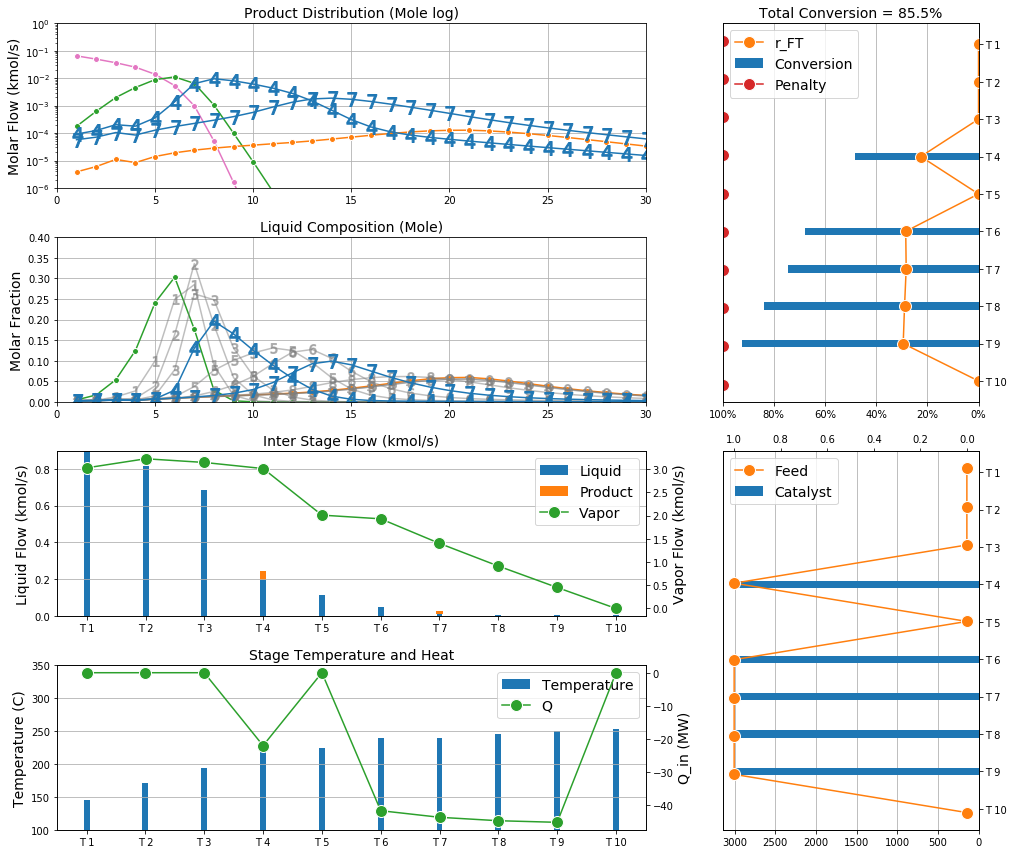

In [2]:
plot_distribution(model)